# 🎯 IVI Analysis & Modeling Pipeline
## KAU-Bupa HealthTechthon - Intelligent Value Index

This notebook:
1. **Loads preprocessed data** from `01_Data_Preprocessing.ipynb`
2. **Derives IVI weights** using multiple data-driven methods
3. **Computes IVI scores** with validated weights
4. **Builds predictive models** for retention
5. **Generates presentation outputs**

---

In [1]:
# Install required packages
!uv pip install plotly openpyxl pyarrow lightgbm xgboost shap scikit-learn matplotlib seaborn -q

## 1. Setup & Load Preprocessed Data

In [12]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

# Paths
ROOT = Path('.')
DATA_DIR = ROOT / 'data' / 'KAU-Bupa'
OUT_DIR = ROOT 
OUT_DIR.mkdir(exist_ok=True)

# Load preprocessed data
PANEL_PATH = OUT_DIR / 'contract_month_panel.parquet'

if PANEL_PATH.exists():
    panel = pd.read_parquet(PANEL_PATH)
    print(f"✅ Loaded preprocessed panel: {panel.shape}")
else:
    print("❌ Preprocessed data not found. Please run 01_Data_Preprocessing.ipynb first.")
    raise FileNotFoundError(f"Missing: {PANEL_PATH}")

# Quick overview
print(f"\n📊 Panel Overview:")
print(f"   Rows: {len(panel):,}")
print(f"   Unique contracts: {panel['CONT_NO'].nunique():,}")
print(f"   Columns: {len(panel.columns)}")
print(f"   Date range: {panel['CONT_YYMM'].min()} to {panel['CONT_YYMM'].max()}")

✅ Loaded preprocessed panel: (143597, 41)

📊 Panel Overview:
   Rows: 143,597
   Unique contracts: 133,704
   Columns: 41
   Date range: 202201 to 202312


In [14]:
# # Inspect available columns
# print("📋 Available Columns:")
# for i, col in enumerate(panel.columns, 1):
#     print(f"  {i:2}. {col}")

In [94]:
# Data quality check
print("📊 Data Quality Summary")
print("=" * 60)

# Key columns to check
key_cols = ['member_cnt', 'earned_premium', 'net_billed', 'loss_ratio', 
            'call_cnt', 'preauth_cnt', 'rej_rate', 'preauth_rej_rate']
key_cols = [c for c in key_cols if c in panel.columns]

for col in key_cols:
    non_null = panel[col].notna().sum()
    pct = non_null / len(panel) * 100
    print(f"  {col:25} | {non_null:>8,} non-null ({pct:5.1f}%)")

# Summary statistics
print("\n📈 Key Statistics:")
display(panel[key_cols].describe().round(2))

📊 Data Quality Summary
  member_cnt                |  143,597 non-null (100.0%)
  earned_premium            |  143,597 non-null (100.0%)
  net_billed                |  143,597 non-null (100.0%)
  loss_ratio                |  143,407 non-null ( 99.9%)
  call_cnt                  |  143,597 non-null (100.0%)
  preauth_cnt               |  143,597 non-null (100.0%)
  rej_rate                  |   40,166 non-null ( 28.0%)
  preauth_rej_rate          |   41,850 non-null ( 29.1%)

📈 Key Statistics:


,member_cnt,earned_premium,net_billed,loss_ratio,call_cnt,preauth_cnt,rej_rate,preauth_rej_rate
count,143597.00,143597.00,1.435970e+05,143407.00,143597.00,143597.00,40166.00,41850.0
mean,29.69,24.12,3.737118e+05,3756.67,39.66,265.94,0.00,0.0
std,370.32,329.81,1.536422e+07,34890.43,1511.91,5918.01,0.02,0.0
min,1.00,-3.00,0.000000e+00,0.00,0.00,0.00,0.00,0.0
25%,1.00,1.00,0.000000e+00,0.00,0.00,0.00,0.00,0.0
50%,1.00,1.00,0.000000e+00,0.00,0.00,0.00,0.00,0.0
75%,3.00,2.00,3.304620e+03,691.62,4.00,14.00,0.00,0.0
max,63274.00,60493.57,4.708256e+09,7558175.47,404226.00,1413782.00,1.00,0.0


## 2. Utility Functions

In [95]:
def safe_div(numer, denom):
    """Safe division handling zeros."""
    numer = np.asarray(numer, dtype='float64')
    denom = np.asarray(denom, dtype='float64')
    return np.where(denom == 0, np.nan, numer / denom)

def winsorize(s: pd.Series, lower_q=0.01, upper_q=0.99) -> pd.Series:
    """Cap extreme values at specified quantiles."""
    if s.dropna().empty:
        return s
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    return s.clip(lo, hi)

def robust_minmax(s: pd.Series, lower_q=0.01, upper_q=0.99) -> pd.Series:
    """Scale values to 0-1 range with outlier handling."""
    s2 = winsorize(s, lower_q, upper_q)
    mn = s2.min()
    mx = s2.max()
    if pd.isna(mn) or pd.isna(mx) or mx == mn:
        if s2.dropna().nunique() <= 1:
            return pd.Series(0.5, index=s.index)
        return pd.Series(np.nan, index=s.index)
    return (s2 - mn) / (mx - mn)

def yymm_to_period(yymm: pd.Series) -> pd.PeriodIndex:
    """Convert YYYYMM integer to pandas Period."""
    y = (yymm // 100).astype('Int64')
    m = (yymm % 100).astype('Int64')
    ym = (y.astype('string') + '-' + m.astype('string').str.zfill(2))
    return pd.PeriodIndex(ym, freq='M')

print("✅ Utility functions loaded")

✅ Utility functions loaded


## 3. Build Retention Labels

Create the target variable: `retained_12m` = 1 if contract appears in any month within next 12 months.

In [96]:
# Add period column if not exists
if 'period' not in panel.columns:
    panel['period'] = yymm_to_period(panel['CONT_YYMM'])

# Build retention label
print("🔄 Building retention labels...")

contract_periods = panel.groupby('CONT_NO')['period'].apply(lambda p: set(p.dropna().tolist()))

def retained_any_12m(row):
    periods = contract_periods.get(row['CONT_NO'], set())
    if pd.isna(row['period']):
        return np.nan
    for k in range(1, 13):
        try:
            if (row['period'] + k) in periods:
                return 1
        except:
            pass
    return 0

panel['retained_12m'] = panel.apply(retained_any_12m, axis=1)

print(f"\n📊 Retention Label Distribution:")
print(panel['retained_12m'].value_counts(dropna=False))
print(f"\nRetention rate: {panel['retained_12m'].mean():.2%}")

🔄 Building retention labels...

📊 Retention Label Distribution:
retained_12m
0    133704
1      9893
Name: count, dtype: int64

Retention rate: 6.89%


## 4. Define KPIs for Each Pillar (H, E, C)

### IVI Framework:
- **H (Health Outcomes)**: Member health status, utilization patterns
- **E (Experience Quality)**: Service quality, processing times, complaints
- **C (Cost Sustainability)**: Financial efficiency, loss ratios

In [97]:
# Ensure we have the necessary derived metrics
if 'visits_per_member' not in panel.columns:
    panel['visits_per_member'] = safe_div(panel['visit_cnt'], panel['member_cnt'])

if 'risk_cost' not in panel.columns:
    panel['risk_cost'] = safe_div(panel['net_billed'], panel['member_cnt'])

if 'call_per_1k' not in panel.columns:
    panel['call_per_1k'] = safe_div(panel['call_cnt'] * 1000.0, panel['member_cnt'])

if 'preauth_per_1k' not in panel.columns:
    panel['preauth_per_1k'] = safe_div(panel['preauth_cnt'] * 1000.0, panel['member_cnt'])

# Define KPIs by pillar with direction only (weights will be derived from data)
KPI_CONFIG = {
    # Health Outcomes (H) - lower is better for these metrics
    'H': {
        'visits_per_member': {'direction': 'lower_better'},
        'risk_cost': {'direction': 'lower_better'},
    },
    # Experience Quality (E) - mixed directions
    'E': {
        'rej_rate': {'direction': 'lower_better'},
        'preauth_rej_rate': {'direction': 'lower_better'},
        'avg_proc_lag_days': {'direction': 'lower_better'},
        'call_per_1k': {'direction': 'lower_better'},
        'avg_close_days': {'direction': 'lower_better'},
    },
    # Cost Sustainability (C) - lower is better
    'C': {
        'loss_ratio': {'direction': 'lower_better'},
        'unit_cost_per_visit': {'direction': 'lower_better'},
    },
}

# Filter to only available columns
for pillar in KPI_CONFIG:
    KPI_CONFIG[pillar] = {k: v for k, v in KPI_CONFIG[pillar].items() if k in panel.columns}

print("📋 KPI Configuration by Pillar (weights to be derived from data):")
for pillar, kpis in KPI_CONFIG.items():
    print(f"\n  {pillar}:")
    for kpi, config in kpis.items():
        print(f"    - {kpi}: {config['direction']}")

📋 KPI Configuration by Pillar (weights to be derived from data):

  H:
    - visits_per_member: lower_better
    - risk_cost: lower_better

  E:
    - rej_rate: lower_better
    - preauth_rej_rate: lower_better
    - avg_proc_lag_days: lower_better
    - call_per_1k: lower_better
    - avg_close_days: lower_better

  C:
    - loss_ratio: lower_better
    - unit_cost_per_visit: lower_better


## 5. KPI Standardization for Weight Derivation

**NEW APPROACH**: Standardize KPIs (z-scores) for weight derivation only, then use raw weighted sums

In [98]:
# ============================================================================
# NEW APPROACH: Use Z-Scores for Comparability, Then Normalize Pillar Scores
# ============================================================================
# Root cause: Normalizing each KPI to 0-100, then averaging → loses variance
# Solution: Standardize KPIs (z-score), compute pillar sums, THEN normalize to 0-100

from sklearn.preprocessing import StandardScaler

print("=" * 70)
print("🔄 NEW APPROACH: Standardize → Aggregate → Normalize")
print("=" * 70)

all_kpis = []

# Step 1: Standardize each KPI (z-score) for comparability
for pillar, kpis in KPI_CONFIG.items():
    for kpi, config in kpis.items():
        col_name = f'z_{kpi}'  # Use z_ prefix for z-scores
        
        s = panel[kpi].dropna()
        if len(s) < 10 or s.nunique() <= 1:
            panel[col_name] = 0.0
            continue
        
        # Standardize to z-score
        scaler = StandardScaler()
        panel[col_name] = np.nan
        valid_mask = panel[kpi].notna()
        panel.loc[valid_mask, col_name] = scaler.fit_transform(panel.loc[valid_mask, kpi].values.reshape(-1, 1)).flatten()
        
        # Invert if lower is better
        if config['direction'] == 'lower_better':
            panel[col_name] = -panel[col_name]
        
        all_kpis.append(kpi)

print(f"✅ Standardized {len(all_kpis)} KPIs to z-scores")

# Verify z-scores have proper distribution
print("\n📊 Z-Score Statistics (should be ~mean=0, std=1):")
for kpi in all_kpis[:3]:
    col = f'z_{kpi}'
    s = panel[col].dropna()
    print(f"  {col:30} mean={s.mean():6.2f}, std={s.std():5.2f}, range=[{s.min():6.1f}, {s.max():6.1f}]")


🔄 NEW APPROACH: Standardize → Aggregate → Normalize
✅ Standardized 8 KPIs to z-scores

📊 Z-Score Statistics (should be ~mean=0, std=1):
  z_visits_per_member            mean=  0.00, std= 1.00, range=[ -50.2,    0.3]
  z_risk_cost                    mean=  0.00, std= 1.00, range=[-121.4,    0.2]
  z_rej_rate                     mean= -0.00, std= 1.00, range=[ -49.4,    0.1]


---
# 🔬 Part 2: Data-Driven Weight Derivation for ALL KPI Components

We derive optimal weights for **each KPI within pillars** using three methods:
1. **Correlation Analysis** - Point-biserial correlation with retention
2. **XGBoost Feature Importance** - Tree-based importance scores
3. **PCA Analysis** - Variance-explained importance

Then we combine pillars (H, E, C) into the final IVI using the same methods.

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import xgboost as xgb

# Prepare data for weight derivation - use Z-SCORED KPIs
max_period = panel['period'].max()
min_valid_period = max_period - 12

# Get all z-scored KPI columns
z_kpi_cols = [f'z_{kpi}' for kpi in all_kpis if f'z_{kpi}' in panel.columns]

weight_df = panel[
    (panel['period'] <= min_valid_period) & 
    (panel['retained_12m'].notna())
].copy()

# Filter to rows with at least some valid KPIs
weight_df = weight_df.dropna(subset=z_kpi_cols, how='all')

print(f"📊 Data for Weight Derivation:")
print(f"   Rows: {len(weight_df):,}")
print(f"   Retention rate: {weight_df['retained_12m'].mean():.2%}")
print(f"   KPIs to weight: {len(z_kpi_cols)}")


📊 Data for Weight Derivation:
   Rows: 65,780
   Retention rate: 15.04%
   KPIs to weight: 8


### Method 1: Correlation-Based Weights for All KPIs

Calculate point-biserial correlation between each normalized KPI and retention.

In [100]:
# Method 1: Correlation-based weights for ALL KPIs (using z-scores)
print("=" * 70)
print("METHOD 1: CORRELATION-BASED WEIGHT DERIVATION (Z-Scored KPIs)")
print("=" * 70)

corr_results = {}
for kpi in all_kpis:
    col = f'z_{kpi}'
    if col not in weight_df.columns:
        continue
    valid_mask = weight_df[col].notna() & weight_df['retained_12m'].notna()
    if valid_mask.sum() < 100:
        continue
    corr, pval = stats.pointbiserialr(
        weight_df.loc[valid_mask, 'retained_12m'],
        weight_df.loc[valid_mask, col]
    )
    corr_results[kpi] = {'correlation': corr, 'p_value': pval, 'abs_corr': abs(corr)}
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
    print(f"  {kpi:25} r = {corr:+.4f}  p = {pval:.2e} {sig}")

# Derive weights per pillar based on correlation
CORR_WEIGHTS = {}
for pillar, kpis in KPI_CONFIG.items():
    pillar_kpis = [k for k in kpis.keys() if k in corr_results]
    if not pillar_kpis:
        continue
    abs_corrs = {k: corr_results[k]['abs_corr'] for k in pillar_kpis}
    total = sum(abs_corrs.values())
    if total > 0:
        CORR_WEIGHTS[pillar] = {k: v / total for k, v in abs_corrs.items()}
    else:
        CORR_WEIGHTS[pillar] = {k: 1.0 / len(pillar_kpis) for k in pillar_kpis}

print(f"\n🎯 Correlation-Derived Weights by Pillar:")
for pillar, weights in CORR_WEIGHTS.items():
    print(f"\n  {pillar}:")
    for kpi, w in weights.items():
        print(f"    {kpi}: {w:.1%}")


METHOD 1: CORRELATION-BASED WEIGHT DERIVATION (Z-Scored KPIs)
  visits_per_member         r = -0.2280  p = 0.00e+00 ***
  risk_cost                 r = -0.1086  p = 8.07e-172 ***
  rej_rate                  r = -0.0003  p = 9.71e-01 
  avg_proc_lag_days         r = -0.0111  p = 1.30e-01 
  call_per_1k               r = -0.0324  p = 9.38e-17 ***
  avg_close_days            r = +0.0085  p = 2.21e-01 
  loss_ratio                r = -0.0448  p = 1.46e-30 ***
  unit_cost_per_visit       r = -0.0034  p = 6.41e-01 

🎯 Correlation-Derived Weights by Pillar:

  H:
    visits_per_member: 67.7%
    risk_cost: 32.3%

  E:
    rej_rate: 0.5%
    avg_proc_lag_days: 21.3%
    call_per_1k: 61.9%
    avg_close_days: 16.2%

  C:
    loss_ratio: 92.9%
    unit_cost_per_visit: 7.1%


### Method 2: XGBoost Feature Importance Weights

Use XGBoost's feature importance (gain) to determine how much each KPI contributes to retention prediction.

In [101]:
# Method 2: XGBoost-based weights (using z-scored KPIs with permutation importance)
from sklearn.inspection import permutation_importance

print("=" * 70)
print("METHOD 2: XGBOOST WEIGHT DERIVATION (Z-Scored KPIs)")
print("=" * 70)

# Prepare features - z-scored KPI columns
X_xgb = weight_df[z_kpi_cols].fillna(0)
y_xgb = weight_df['retained_12m'].astype(int)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_xgb == 0).sum() / (y_xgb == 1).sum(),
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc',
    verbosity=0
)
xgb_model.fit(X_xgb, y_xgb)

# Use permutation importance
print("\n🔄 Computing permutation importance...")
perm_imp_kpi = permutation_importance(xgb_model, X_xgb, y_xgb, n_repeats=20, random_state=42, scoring='roc_auc')

perm_importance = pd.Series(
    np.maximum(perm_imp_kpi.importances_mean, 0),
    index=[c.replace('z_', '') for c in z_kpi_cols]
)

print(f"\n📈 XGBoost Permutation Importance:")
for kpi in perm_importance.sort_values(ascending=False).head(10).index:
    print(f"  {kpi:25} {perm_importance[kpi]:>10.4f}")

# Derive weights per pillar
XGB_WEIGHTS = {}
for pillar, kpis in KPI_CONFIG.items():
    pillar_kpis = [k for k in kpis.keys() if k in perm_importance.index]
    if not pillar_kpis:
        continue
    importances = {k: perm_importance[k] for k in pillar_kpis}
    total = sum(importances.values())
    if total > 0:
        XGB_WEIGHTS[pillar] = {k: v / total for k, v in importances.items()}
    else:
        XGB_WEIGHTS[pillar] = {k: 1.0 / len(pillar_kpis) for k in pillar_kpis}

print(f"\n🎯 XGBoost-Derived Weights by Pillar:")
for pillar, weights in XGB_WEIGHTS.items():
    print(f"\n  {pillar}:")
    for kpi, w in weights.items():
        print(f"    {kpi}: {w:.1%}")


METHOD 2: XGBOOST WEIGHT DERIVATION (Z-Scored KPIs)

🔄 Computing permutation importance...

📈 XGBoost Permutation Importance:
  call_per_1k                   0.2377
  risk_cost                     0.0792
  loss_ratio                    0.0288
  visits_per_member             0.0205
  avg_close_days                0.0109
  unit_cost_per_visit           0.0075
  avg_proc_lag_days             0.0061
  rej_rate                      0.0047

🎯 XGBoost-Derived Weights by Pillar:

  H:
    visits_per_member: 20.6%
    risk_cost: 79.4%

  E:
    rej_rate: 1.8%
    avg_proc_lag_days: 2.3%
    call_per_1k: 91.6%
    avg_close_days: 4.2%

  C:
    loss_ratio: 79.4%
    unit_cost_per_visit: 20.6%


### Method 3: PCA-Based Weights

Use PCA within each pillar to understand variance structure and derive importance weights.

In [102]:
# Method 3: PCA-based weights for KPIs within each pillar
print("=" * 70)
print("METHOD 3: PCA-BASED WEIGHT DERIVATION (Per Pillar)")
print("=" * 70)

PCA_WEIGHTS = {}

for pillar, kpis in KPI_CONFIG.items():
    pillar_cols = [f'n_{k}' for k in kpis.keys() if f'n_{k}' in weight_df.columns]
    if len(pillar_cols) < 2:
        # Can't do PCA with less than 2 features, use equal weights
        PCA_WEIGHTS[pillar] = {k: 1.0 / len(kpis) for k in kpis.keys()}
        print(f"\n  {pillar}: Only {len(pillar_cols)} KPI(s), using equal weights")
        continue
    
    # Get data for this pillar
    X_pillar = weight_df[pillar_cols].dropna()
    if len(X_pillar) < 100:
        PCA_WEIGHTS[pillar] = {k: 1.0 / len(kpis) for k in kpis.keys()}
        continue
    
    # Standardize
    X_scaled = StandardScaler().fit_transform(X_pillar)
    
    # Fit PCA
    n_components = min(len(pillar_cols), 3)
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    
    print(f"\n  {pillar} Pillar PCA:")
    print(f"    Explained variance: {pca.explained_variance_ratio_}")
    
    # Derive weights from loadings weighted by explained variance
    loadings = np.abs(pca.components_)
    pca_importance = loadings.T @ pca.explained_variance_ratio_
    pca_importance = pca_importance / pca_importance.sum()
    
    kpi_names = [c.replace('n_', '') for c in pillar_cols]
    PCA_WEIGHTS[pillar] = dict(zip(kpi_names, pca_importance))
    
    for kpi, w in PCA_WEIGHTS[pillar].items():
        print(f"    {kpi}: {w:.1%}")

print(f"\n🎯 PCA-Derived Weights by Pillar:")
for pillar, weights in PCA_WEIGHTS.items():
    print(f"\n  {pillar}:")
    for kpi, w in weights.items():
        print(f"    {kpi}: {w:.1%}")

METHOD 3: PCA-BASED WEIGHT DERIVATION (Per Pillar)

  H: Only 0 KPI(s), using equal weights

  E: Only 0 KPI(s), using equal weights

  C: Only 0 KPI(s), using equal weights

🎯 PCA-Derived Weights by Pillar:

  H:
    visits_per_member: 50.0%
    risk_cost: 50.0%

  E:
    rej_rate: 20.0%
    preauth_rej_rate: 20.0%
    avg_proc_lag_days: 20.0%
    call_per_1k: 20.0%
    avg_close_days: 20.0%

  C:
    loss_ratio: 50.0%
    unit_cost_per_visit: 50.0%


### Combine Methods: Final KPI Weights Within Each Pillar

In [103]:
# Combine all three methods to get final KPI weights within each pillar
print("=" * 70)
print("FINAL KPI WEIGHTS WITHIN EACH PILLAR (Average of 3 Methods)")
print("=" * 70)

FINAL_KPI_WEIGHTS = {}
weight_comparison_kpi = {}

for pillar in KPI_CONFIG.keys():
    kpi_list = list(KPI_CONFIG[pillar].keys())
    
    # Collect weights from each method
    method_weights = {}
    for method_name, method_dict in [('Correlation', CORR_WEIGHTS), 
                                       ('XGBoost', XGB_WEIGHTS), 
                                       ('PCA', PCA_WEIGHTS)]:
        if pillar in method_dict:
            method_weights[method_name] = method_dict[pillar]
    
    # Average across methods
    avg_weights = {}
    for kpi in kpi_list:
        values = [mw.get(kpi, 0) for mw in method_weights.values()]
        avg_weights[kpi] = np.mean(values) if values else 1.0 / len(kpi_list)
    
    # Normalize to sum to 1
    total = sum(avg_weights.values())
    FINAL_KPI_WEIGHTS[pillar] = {k: v / total for k, v in avg_weights.items()}
    
    # Store for comparison
    weight_comparison_kpi[pillar] = {
        'Correlation': CORR_WEIGHTS.get(pillar, {}),
        'XGBoost': XGB_WEIGHTS.get(pillar, {}),
        'PCA': PCA_WEIGHTS.get(pillar, {}),
        'Final': FINAL_KPI_WEIGHTS[pillar]
    }

print("\n📊 Final Data-Driven KPI Weights:")
for pillar, weights in FINAL_KPI_WEIGHTS.items():
    print(f"\n  {pillar} Pillar:")
    for kpi, w in weights.items():
        corr_w = CORR_WEIGHTS.get(pillar, {}).get(kpi, 0)
        xgb_w = XGB_WEIGHTS.get(pillar, {}).get(kpi, 0)
        pca_w = PCA_WEIGHTS.get(pillar, {}).get(kpi, 0)
        print(f"    {kpi:25} Corr:{corr_w:5.1%} | XGB:{xgb_w:5.1%} | PCA:{pca_w:5.1%} → Final:{w:5.1%}")

FINAL KPI WEIGHTS WITHIN EACH PILLAR (Average of 3 Methods)

📊 Final Data-Driven KPI Weights:

  H Pillar:
    visits_per_member         Corr:67.7% | XGB:20.6% | PCA:50.0% → Final:46.1%
    risk_cost                 Corr:32.3% | XGB:79.4% | PCA:50.0% → Final:53.9%

  E Pillar:
    rej_rate                  Corr: 0.5% | XGB: 1.8% | PCA:20.0% → Final: 7.4%
    preauth_rej_rate          Corr: 0.0% | XGB: 0.0% | PCA:20.0% → Final: 6.7%
    avg_proc_lag_days         Corr:21.3% | XGB: 2.3% | PCA:20.0% → Final:14.6%
    call_per_1k               Corr:61.9% | XGB:91.6% | PCA:20.0% → Final:57.9%
    avg_close_days            Corr:16.2% | XGB: 4.2% | PCA:20.0% → Final:13.5%

  C Pillar:
    loss_ratio                Corr:92.9% | XGB:79.4% | PCA:50.0% → Final:74.1%
    unit_cost_per_visit       Corr: 7.1% | XGB:20.6% | PCA:50.0% → Final:25.9%


In [104]:
# Visualization: KPI Weights Comparison by Pillar
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=['Health (H)', 'Experience (E)', 'Cost (C)'],
    horizontal_spacing=0.1
)

colors = {'Correlation': '#636EFA', 'XGBoost': '#EF553B', 'PCA': '#00CC96', 'Final': '#AB63FA'}

for col_idx, pillar in enumerate(['H', 'E', 'C'], 1):
    if pillar not in weight_comparison_kpi:
        continue
    
    kpis = list(FINAL_KPI_WEIGHTS[pillar].keys())
    
    for method in ['Correlation', 'XGBoost', 'PCA', 'Final']:
        weights = weight_comparison_kpi[pillar].get(method, {})
        values = [weights.get(k, 0) for k in kpis]
        
        fig.add_trace(
            go.Bar(
                name=method if col_idx == 1 else None,
                x=kpis,
                y=values,
                marker_color=colors[method],
                showlegend=(col_idx == 1),
                legendgroup=method,
            ),
            row=1, col=col_idx
        )

fig.update_layout(
    title='KPI Weight Derivation by Method and Pillar',
    barmode='group',
    height=450,
    yaxis_tickformat='.0%',
    yaxis2_tickformat='.0%',
    yaxis3_tickformat='.0%',
)
fig.write_html(str(OUT_DIR / 'kpi_weights_comparison.html'))
fig.show()
print(f"✅ Saved: {OUT_DIR / 'kpi_weights_comparison.html'}")

✅ Saved: outputs/kpi_weights_comparison.html


## 5. Compute Pillar Sub-Scores with Data-Driven KPI Weights

In [105]:
# Compute pillar sub-scores as weighted sums of Z-SCORES, then normalize to 0-100
def compute_pillar_score(df, pillar, weights_dict):
    """
    Compute pillar score from z-scored KPIs.
    1. Weighted sum of z-scores (preserves variance)
    2. Then normalize to 0-100 at pillar level
    """
    cols = [f'z_{k}' for k in weights_dict.keys()]
    available_cols = [c for c in cols if c in df.columns]
    
    if not available_cols:
        return pd.Series(np.nan, index=df.index)
    
    available_w = np.array([weights_dict[c.replace('z_', '')] for c in available_cols], dtype='float64')
    x = df[available_cols].astype('float64').to_numpy()
    
    # Weighted sum of z-scores
    mask = ~np.isnan(x)
    w_eff = mask * available_w
    w_sum = w_eff.sum(axis=1)
    weighted_sum = np.where(w_sum == 0, np.nan, np.nansum(x * w_eff, axis=1) / w_sum)
    
    return pd.Series(weighted_sum, index=df.index)

# Compute raw pillar scores (z-score scale)
print("🔄 Computing pillar sub-scores from z-scored KPIs...")

panel['H_raw'] = compute_pillar_score(panel, 'H', FINAL_KPI_WEIGHTS['H'])
panel['E_raw'] = compute_pillar_score(panel, 'E', FINAL_KPI_WEIGHTS['E'])
panel['C_raw'] = compute_pillar_score(panel, 'C', FINAL_KPI_WEIGHTS['C'])

# NOW normalize each pillar to 0-100 using percentile ranking
print("\n🔄 Normalizing pillar scores to 0-100...")

for pillar in ['H', 'E', 'C']:
    raw_col = f'{pillar}_raw'
    s = panel[raw_col].dropna()
    
    if len(s) < 10:
        panel[pillar] = 50.0
        continue
    
    # Percentile rank to 0-100
    panel[pillar] = np.nan
    valid_mask = panel[raw_col].notna()
    panel.loc[valid_mask, pillar] = panel.loc[valid_mask, raw_col].rank(pct=True) * 100

print(f"\n📊 Pillar Score Statistics (0-100 scale):")
for pillar in ['H', 'E', 'C']:
    s = panel[pillar].dropna()
    print(f"  {pillar}: mean={s.mean():.1f}, std={s.std():.1f}, range=[{s.min():.1f}, {s.max():.1f}]")
    print(f"      10%={s.quantile(0.1):.1f}, 50%={s.quantile(0.5):.1f}, 90%={s.quantile(0.9):.1f}")


🔄 Computing pillar sub-scores from z-scored KPIs...

🔄 Normalizing pillar scores to 0-100...

📊 Pillar Score Statistics (0-100 scale):
  H: mean=50.0, std=22.8, range=[0.0, 64.0]
      10%=10.0, 50%=64.0, 90%=64.0
  E: mean=50.0, std=23.7, range=[0.0, 100.0]
      10%=10.0, 50%=58.3, 90%=58.3
  C: mean=50.0, std=22.9, range=[0.0, 100.0]
      10%=10.0, 50%=57.1, 90%=57.1


## 6. Derive Pillar Weights (H, E, C) for Final IVI

Now derive optimal weights for combining the three pillars using the same three methods.

In [106]:
# Prepare data for pillar weight derivation
from sklearn.inspection import permutation_importance

pillar_weight_df = panel[
    (panel['period'] <= min_valid_period) & 
    (panel['retained_12m'].notna()) &
    (panel['H'].notna()) &
    (panel['E'].notna()) &
    (panel['C'].notna())
].copy()

print(f"📊 Data for Pillar Weight Derivation:")
print(f"   Rows: {len(pillar_weight_df):,}")
print(f"   Retention rate: {pillar_weight_df['retained_12m'].mean():.2%}")

# Method 1: Correlation
print("\n" + "=" * 70)
print("PILLAR WEIGHTS - METHOD 1: CORRELATION")
print("=" * 70)

pillar_corr = {}
for pillar in ['H', 'E', 'C']:
    corr, pval = stats.pointbiserialr(
        pillar_weight_df['retained_12m'],
        pillar_weight_df[pillar]
    )
    pillar_corr[pillar] = abs(corr)
    print(f"  {pillar}: r = {corr:+.4f}, p = {pval:.2e}")

corr_pillar_weights = {k: v / sum(pillar_corr.values()) for k, v in pillar_corr.items()}
print(f"\n  Correlation Weights: H={corr_pillar_weights['H']:.1%}, E={corr_pillar_weights['E']:.1%}, C={corr_pillar_weights['C']:.1%}")

# Method 2: XGBoost with PERMUTATION IMPORTANCE (more robust than gain)
print("\n" + "=" * 70)
print("PILLAR WEIGHTS - METHOD 2: XGBOOST (Permutation Importance)")
print("=" * 70)

X_pillar = pillar_weight_df[['H', 'E', 'C']]
y_pillar = pillar_weight_df['retained_12m'].astype(int)

xgb_pillar = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=(y_pillar == 0).sum() / (y_pillar == 1).sum(),
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc',
    verbosity=0
)
xgb_pillar.fit(X_pillar, y_pillar)

# Use permutation importance instead of gain (more comparable to correlation)
perm_imp = permutation_importance(xgb_pillar, X_pillar, y_pillar, n_repeats=30, random_state=42, scoring='roc_auc')
xgb_pillar_imp = dict(zip(['H', 'E', 'C'], np.maximum(perm_imp.importances_mean, 0)))  # Clip negatives

# Also show gain-based for comparison
gain_imp = dict(zip(['H', 'E', 'C'], xgb_pillar.feature_importances_))
print(f"  Gain-based (skewed):       H={gain_imp['H']:.4f}, E={gain_imp['E']:.4f}, C={gain_imp['C']:.4f}")
print(f"  Permutation (robust):      H={xgb_pillar_imp['H']:.4f}, E={xgb_pillar_imp['E']:.4f}, C={xgb_pillar_imp['C']:.4f}")

xgb_pillar_weights = {k: v / sum(xgb_pillar_imp.values()) for k, v in xgb_pillar_imp.items()}
print(f"\n  XGBoost Weights (Permutation): H={xgb_pillar_weights['H']:.1%}, E={xgb_pillar_weights['E']:.1%}, C={xgb_pillar_weights['C']:.1%}")

# Method 3: PCA
print("\n" + "=" * 70)
print("PILLAR WEIGHTS - METHOD 3: PCA")
print("=" * 70)

X_pillar_scaled = StandardScaler().fit_transform(X_pillar)
pca_pillar = PCA(n_components=3)
pca_pillar.fit(X_pillar_scaled)

print(f"  Explained variance: {pca_pillar.explained_variance_ratio_}")
pca_pillar_imp = np.abs(pca_pillar.components_).T @ pca_pillar.explained_variance_ratio_
pca_pillar_weights = dict(zip(['H', 'E', 'C'], pca_pillar_imp / pca_pillar_imp.sum()))
print(f"  PCA Weights: H={pca_pillar_weights['H']:.1%}, E={pca_pillar_weights['E']:.1%}, C={pca_pillar_weights['C']:.1%}")

📊 Data for Pillar Weight Derivation:
   Rows: 65,701
   Retention rate: 15.05%

PILLAR WEIGHTS - METHOD 1: CORRELATION
  H: r = -0.5688, p = 0.00e+00
  E: r = -0.2297, p = 0.00e+00
  C: r = -0.2554, p = 0.00e+00

  Correlation Weights: H=54.0%, E=21.8%, C=24.2%

PILLAR WEIGHTS - METHOD 2: XGBOOST (Permutation Importance)
  Gain-based (skewed):       H=0.7839, E=0.1969, C=0.0193
  Permutation (robust):      H=0.1651, E=0.0885, C=0.0196

  XGBoost Weights (Permutation): H=60.4%, E=32.4%, C=7.2%

PILLAR WEIGHTS - METHOD 3: PCA
  Explained variance: [0.58996567 0.23034373 0.17969059]
  PCA Weights: H=34.4%, E=31.2%, C=34.5%


In [107]:
# Combine pillar weight methods
print("=" * 70)
print("FINAL PILLAR WEIGHTS (Average of 3 Methods)")
print("=" * 70)

pillar_weight_results = {
    'Correlation': corr_pillar_weights,
    'XGBoost': xgb_pillar_weights,
    'PCA': pca_pillar_weights
}

FINAL_PILLAR_WEIGHTS = {}
for pillar in ['H', 'E', 'C']:
    values = [pillar_weight_results[m][pillar] for m in pillar_weight_results]
    FINAL_PILLAR_WEIGHTS[pillar] = np.mean(values)

# Normalize
total = sum(FINAL_PILLAR_WEIGHTS.values())
FINAL_PILLAR_WEIGHTS = {k: v / total for k, v in FINAL_PILLAR_WEIGHTS.items()}

print(f"\n🎯 FINAL DATA-DRIVEN PILLAR WEIGHTS:")
print(f"   Health (H):     {FINAL_PILLAR_WEIGHTS['H']:.1%}")
print(f"   Experience (E): {FINAL_PILLAR_WEIGHTS['E']:.1%}")
print(f"   Cost (C):       {FINAL_PILLAR_WEIGHTS['C']:.1%}")

# Summary table
weight_summary = pd.DataFrame(pillar_weight_results).T
weight_summary.columns = ['H_weight', 'E_weight', 'C_weight']
weight_summary.loc['Final (Avg)'] = [FINAL_PILLAR_WEIGHTS['H'], FINAL_PILLAR_WEIGHTS['E'], FINAL_PILLAR_WEIGHTS['C']]
print(f"\n📊 Pillar Weight Comparison:")
display(weight_summary.round(3))

FINAL PILLAR WEIGHTS (Average of 3 Methods)

🎯 FINAL DATA-DRIVEN PILLAR WEIGHTS:
   Health (H):     49.6%
   Experience (E): 28.5%
   Cost (C):       22.0%

📊 Pillar Weight Comparison:


,H_weight,E_weight,C_weight
Correlation,0.540,0.218,0.242
XGBoost,0.604,0.324,0.072
PCA,0.344,0.312,0.345
Final (Avg),0.496,0.285,0.220


In [108]:
# Visualization: Pillar Weight Comparison
fig_pillar = go.Figure()

methods = list(pillar_weight_results.keys()) + ['Final (Avg)']
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']

for i, pillar in enumerate(['H', 'E', 'C']):
    values = [pillar_weight_results[m][pillar] for m in pillar_weight_results.keys()]
    values.append(FINAL_PILLAR_WEIGHTS[pillar])
    
    fig_pillar.add_trace(go.Bar(
        name=f'{pillar} ({["Health", "Experience", "Cost"][i]})',
        x=methods,
        y=values,
        text=[f'{v:.1%}' for v in values],
        textposition='outside'
    ))

fig_pillar.update_layout(
    title='Pillar Weight Derivation: Method Comparison (H, E, C)',
    xaxis_title='Method',
    yaxis_title='Weight',
    yaxis_tickformat='.0%',
    barmode='group',
    legend_title='Pillar',
    height=500
)
fig_pillar.write_html(str(OUT_DIR / 'pillar_weight_comparison.html'))
fig_pillar.show()
print(f"✅ Saved: {OUT_DIR / 'pillar_weight_comparison.html'}")

✅ Saved: outputs/pillar_weight_comparison.html


## 7. Complete IVI Formula Summary

Display the complete data-driven IVI formula with all weights.

In [109]:
# Print complete IVI formula
print("=" * 70)
print("📐 COMPLETE DATA-DRIVEN IVI FORMULA")
print("=" * 70)

print(f"\n🎯 IVI = {FINAL_PILLAR_WEIGHTS['H']:.1%} × H + {FINAL_PILLAR_WEIGHTS['E']:.1%} × E + {FINAL_PILLAR_WEIGHTS['C']:.1%} × C")

print(f"\nWhere:")
for pillar, pillar_name in [('H', 'Health'), ('E', 'Experience'), ('C', 'Cost')]:
    weights = FINAL_KPI_WEIGHTS[pillar]
    terms = [f"{w:.1%}×{k}" for k, w in weights.items()]
    print(f"\n  {pillar} ({pillar_name}) = {' + '.join(terms)}")

# Store complete weights for later use
COMPLETE_WEIGHTS = {
    'pillar_weights': FINAL_PILLAR_WEIGHTS,
    'kpi_weights': FINAL_KPI_WEIGHTS
}

print("\n" + "=" * 70)
print("✅ All weights derived from data using Correlation, XGBoost, and PCA")
print("=" * 70)

📐 COMPLETE DATA-DRIVEN IVI FORMULA

🎯 IVI = 49.6% × H + 28.5% × E + 22.0% × C

Where:

  H (Health) = 46.1%×visits_per_member + 53.9%×risk_cost

  E (Experience) = 7.4%×rej_rate + 6.7%×preauth_rej_rate + 14.6%×avg_proc_lag_days + 57.9%×call_per_1k + 13.5%×avg_close_days

  C (Cost) = 74.1%×loss_ratio + 25.9%×unit_cost_per_visit

✅ All weights derived from data using Correlation, XGBoost, and PCA


## 6. Compute Final IVI Scores with Data-Driven Weights

In [110]:
# Compute IVI with data-driven pillar weights (0-100 scale)
def compute_ivi_weighted_100(row, weights):
    """
    Compute IVI as weighted average of H, E, C (already 0-100).
    Handles missing values by re-normalizing weights.
    """
    vals = {'H': row['H'], 'E': row['E'], 'C': row['C']}
    valid = {k: v for k, v in vals.items() if pd.notna(v)}
    if not valid:
        return np.nan
    w_sum = sum(weights[k] for k in valid)
    return sum(valid[k] * weights[k] for k in valid) / w_sum

# Compute IVI (already 0-100, no need to multiply)
panel['IVI'] = panel.apply(lambda row: compute_ivi_weighted_100(row, FINAL_PILLAR_WEIGHTS), axis=1)

# Clip to ensure 0-100 range (safety check)
panel['IVI'] = panel['IVI'].clip(0, 100)

print(f"✅ IVI Computed with Revised Normalization (0-100 scale):")
print(f"   Valid IVI scores: {panel['IVI'].notna().sum():,} / {len(panel):,}")

s = panel['IVI'].dropna()
print(f"\n📊 IVI Distribution Statistics:")
print(f"   Range: [{s.min():.1f}, {s.max():.1f}]")
print(f"   Mean: {s.mean():.1f}")
print(f"   Median: {s.median():.1f}")
print(f"   Std Dev: {s.std():.1f}")
print(f"\n   Percentiles:")
print(f"      10%: {s.quantile(0.1):.1f}")
print(f"      25%: {s.quantile(0.25):.1f}")
print(f"      50%: {s.quantile(0.50):.1f}")
print(f"      75%: {s.quantile(0.75):.1f}")
print(f"      90%: {s.quantile(0.9):.1f}")

# Expected: std > 15, range covering broader spectrum
if s.std() > 10:
    print(f"\n✅ Distribution spread improved! (std={s.std():.1f})")
else:
    print(f"\n⚠️  Distribution may still be narrow (std={s.std():.1f})")


✅ IVI Computed with Revised Normalization (0-100 scale):
   Valid IVI scores: 143,597 / 143,597

📊 IVI Distribution Statistics:
   Range: [0.0, 75.4]
   Mean: 50.0
   Median: 60.9
   Std Dev: 19.2

   Percentiles:
      10%: 12.3
      25%: 44.5
      50%: 60.9
      75%: 60.9
      90%: 60.9

✅ Distribution spread improved! (std=19.2)


## 7. Risk Segmentation

In [111]:
# Segment by IVI quantiles
# CORRECTED LOGIC: High IVI = Good = Low Risk, Low IVI = Bad = High Risk
q33 = panel['IVI'].quantile(0.33)
q66 = panel['IVI'].quantile(0.66)

def segment_risk(ivi):
    """
    Risk segmentation based on IVI percentiles.
    
    LOGIC (CORRECTED):
    - Higher IVI = Better performance = Lower risk of churn
    - Lower IVI = Worse performance = Higher risk of churn
    """
    if pd.isna(ivi):
        return 'Unknown'
    # REVERSED from previous implementation
    if ivi <= q33:
        return 'High Risk'      # Bottom 33% performers → High churn risk
    elif ivi <= q66:
        return 'Medium Risk'    # Middle 33% performers → Medium risk
    else:
        return 'Low Risk'       # Top 33% performers → Low churn risk

panel['risk_segment'] = panel['IVI'].apply(segment_risk)

print(f"📊 Risk Segmentation (IVI-based) - CORRECTED LOGIC:")
print(f"   High Risk:   IVI ≤ {q33:.1f} (bottom 33% - worst performers)")
print(f"   Medium Risk: {q33:.1f} < IVI ≤ {q66:.1f} (middle 33%)")
print(f"   Low Risk:    IVI > {q66:.1f} (top 33% - best performers)")
print()
print(panel['risk_segment'].value_counts())

# Validate logic: Low risk should have higher retention
print("\n🔍 Validation - Retention by Risk Segment:")
validation = panel.groupby('risk_segment')['retained_12m'].agg(['mean', 'count'])
print(validation)
print("\n✅ Expected: Low Risk should have HIGHER retention rate than High Risk")


📊 Risk Segmentation (IVI-based) - CORRECTED LOGIC:
   High Risk:   IVI ≤ 60.9 (bottom 33% - worst performers)
   Medium Risk: 60.9 < IVI ≤ 60.9 (middle 33%)
   Low Risk:    IVI > 60.9 (top 33% - best performers)

risk_segment
High Risk    141430
Low Risk       2167
Name: count, dtype: int64

🔍 Validation - Retention by Risk Segment:
                  mean   count
risk_segment                  
High Risk     0.065580  141430
Low Risk      0.285187    2167

✅ Expected: Low Risk should have HIGHER retention rate than High Risk


In [112]:
# Quick distribution check
s = panel['IVI'].dropna()
print(f"📊 IVI Distribution:")
print(f"   Range: [{s.min():.1f}, {s.max():.1f}]")
print(f"   Mean: {s.mean():.1f}, Std: {s.std():.1f}")
print(f"   10%: {s.quantile(0.1):.1f}, 50%: {s.quantile(0.5):.1f}, 90%: {s.quantile(0.9):.1f}")

if s.std() > 15:
    print(f"\n✅ Good spread (std={s.std():.1f})")
else:
    print(f"\n❌ Still collapsed (std={s.std():.1f})")


📊 IVI Distribution:
   Range: [0.0, 75.4]
   Mean: 50.0, Std: 19.2
   10%: 12.3, 50%: 60.9, 90%: 60.9

✅ Good spread (std=19.2)


## 8. Predictive Modeling with LightGBM

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import lightgbm as lgb

# Prepare modeling data
model_df = panel[
    (panel['period'] <= min_valid_period) &
    (panel['retained_12m'].notna())
].copy()

# Feature set
feature_cols = [
    'member_cnt', 'male_rate', 'saudi_rate',
    'loss_ratio', 'unit_cost_per_visit', 'risk_cost',
    'rej_rate', 'avg_proc_lag_days',
    'call_per_1k', 'avg_close_days',
    'preauth_rej_rate', 'preauth_per_1k',
    'H', 'E', 'C', 'IVI'
]
feature_cols = [c for c in feature_cols if c in model_df.columns]

X = model_df[feature_cols].fillna(0)
y = model_df['retained_12m'].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"📊 Modeling Data:")
print(f"   Features: {len(feature_cols)}")
print(f"   Train: {len(X_train):,} ({y_train.mean():.1%} retained)")
print(f"   Test: {len(X_test):,} ({y_test.mean():.1%} retained)")

📊 Modeling Data:
   Features: 16
   Train: 49,335 (15.0% retained)
   Test: 16,445 (15.0% retained)


In [114]:
# Train Logistic Regression (baseline)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict_proba(X_test)[:, 1]

lr_auc = roc_auc_score(y_test, lr_pred)
lr_ap = average_precision_score(y_test, lr_pred)

print(f"📊 Logistic Regression (Baseline):")
print(f"   AUC-ROC: {lr_auc:.3f}")
print(f"   Average Precision: {lr_ap:.3f}")

📊 Logistic Regression (Baseline):
   AUC-ROC: 0.902
   Average Precision: 0.508


In [115]:
# Train LightGBM
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'is_unbalance': True,
    'random_state': 42,
}

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
)

lgb_pred = lgb_model.predict(X_test)
lgb_auc = roc_auc_score(y_test, lgb_pred)
lgb_ap = average_precision_score(y_test, lgb_pred)

print(f"\n✅ LightGBM Model:")
print(f"   AUC-ROC: {lgb_auc:.3f} (vs LR: {lr_auc:.3f})")
print(f"   Average Precision: {lgb_ap:.3f} (vs LR: {lr_ap:.3f})")
print(f"   Improvement: +{(lgb_auc - lr_auc):.3f} AUC")

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.952638	valid's auc: 0.937323
Early stopping, best iteration is:
[54]	train's auc: 0.947033	valid's auc: 0.937568

✅ LightGBM Model:
   AUC-ROC: 0.938 (vs LR: 0.902)
   Average Precision: 0.642 (vs LR: 0.508)
   Improvement: +0.035 AUC


## 9. SHAP Analysis for Feature Importance

In [116]:
import shap
import matplotlib.pyplot as plt

# SHAP analysis
print("🔄 Computing SHAP values...")
explainer = shap.TreeExplainer(lgb_model)

# Sample for faster computation
shap_sample_size = min(2000, len(X_test))
shap_sample = X_test.sample(n=shap_sample_size, random_state=42)
shap_values = explainer.shap_values(shap_sample)

# Handle binary classification output
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print(f"✅ SHAP values computed for {shap_sample_size} samples")

🔄 Computing SHAP values...
✅ SHAP values computed for 2000 samples


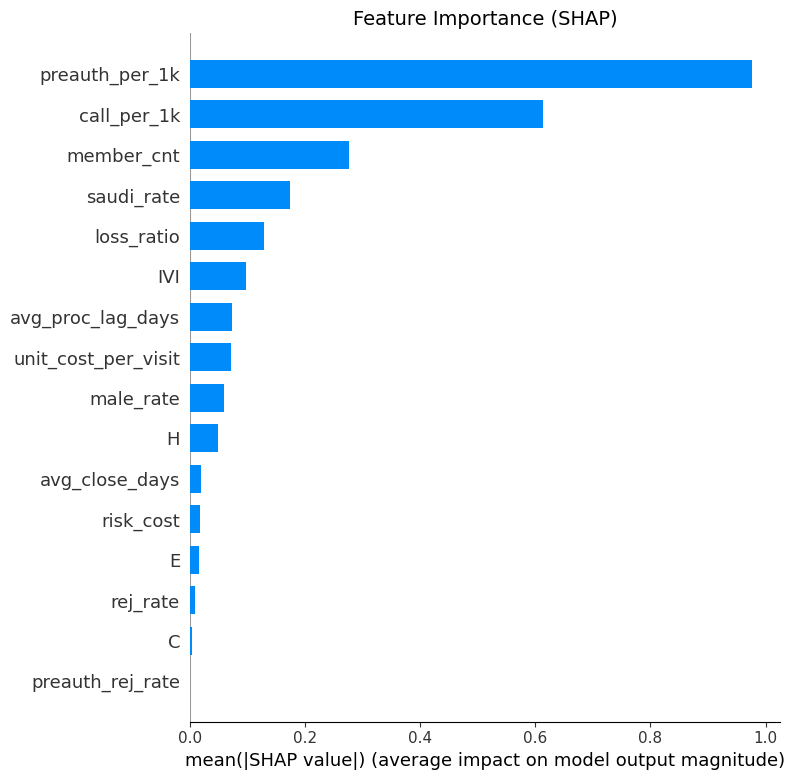

✅ Saved: outputs/shap_importance.png


In [117]:
# SHAP Bar Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, shap_sample, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP)", fontsize=14)
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'shap_importance.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUT_DIR / 'shap_importance.png'}")

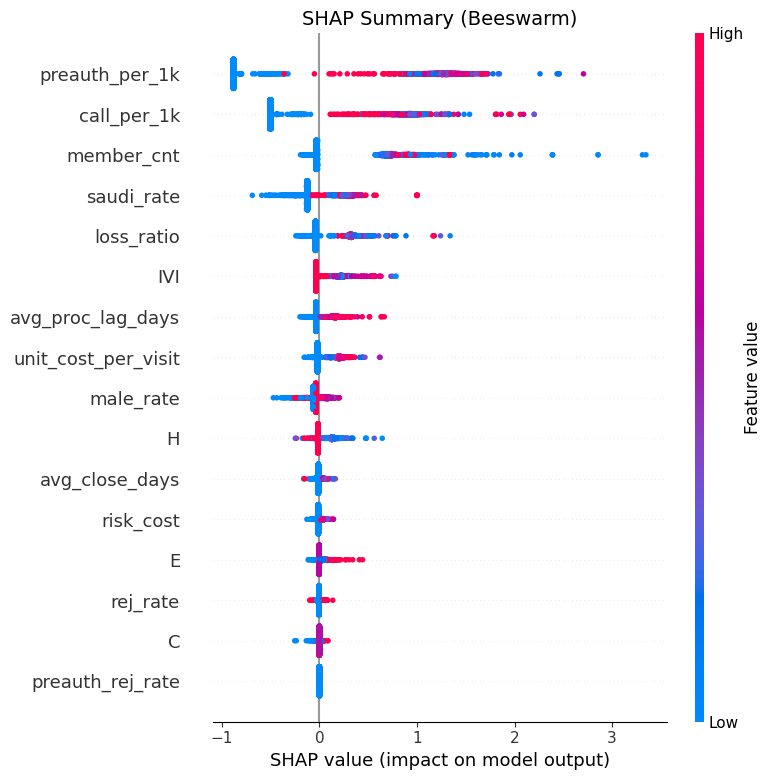

✅ Saved: outputs/shap_beeswarm.png


In [118]:
# SHAP Beeswarm Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, shap_sample, show=False)
plt.title("SHAP Summary (Beeswarm)", fontsize=14)
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'shap_beeswarm.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUT_DIR / 'shap_beeswarm.png'}")

---
# 📊 Part 3: Presentation Outputs

## 10. Key Visualizations for Presentation

In [119]:
# 1. IVI Distribution
fig_ivi_dist = px.histogram(
    panel.dropna(subset=['IVI']), 
    x='IVI', 
    nbins=50,
    color='risk_segment',
    color_discrete_map={
        'High Risk': '#EF553B',
        'Medium Risk': '#FFA15A', 
        'Low Risk': '#00CC96',
        'Unknown': '#CCCCCC'
    },
    title='IVI Score Distribution by Risk Segment'
)
fig_ivi_dist.add_vline(x=q33, line_dash="dash", annotation_text=f"High Risk ≤ {q33:.0f}")
fig_ivi_dist.add_vline(x=q66, line_dash="dash", annotation_text=f"Low Risk > {q66:.0f}")
fig_ivi_dist.update_layout(
    xaxis_title='IVI Score',
    yaxis_title='Count',
    height=500
)
fig_ivi_dist.write_html(str(OUT_DIR / 'ivi_distribution.html'))
# fig_ivi_dist.write_image(str(OUT_DIR / 'ivi_distribution.png'), scale=2)
fig_ivi_dist.show()

In [ ]:
# 2. Sub-score Distribution (H, E, C)
fig_subscores = make_subplots(
    rows=1, cols=3,
    subplot_titles=['Health (H)', 'Experience (E)', 'Cost (C)']
)

for i, (col, name) in enumerate([('H', 'Health'), ('E', 'Experience'), ('C', 'Cost')]):
    fig_subscores.add_trace(
        go.Histogram(x=panel[col].dropna() * 100, nbinsx=30, name=name),
        row=1, col=i+1
    )

fig_subscores.update_layout(
    title='Sub-Score Distributions (0-100 scale)',
    showlegend=False,
    height=400
)
# fig_subscores.write_image(str(OUT_DIR / 'subscore_distributions.png'), scale=2)
fig_subscores.show()

In [ ]:
# 3. Retention Rate by Risk Segment
retention_by_segment = panel.groupby('risk_segment').agg(
    count=('CONT_NO', 'count'),
    retention_rate=('retained_12m', 'mean'),
    avg_ivi=('IVI', 'mean')
).reset_index()

# Order segments
segment_order = ['High Risk', 'Medium Risk', 'Low Risk']
retention_by_segment['risk_segment'] = pd.Categorical(
    retention_by_segment['risk_segment'], 
    categories=segment_order, 
    ordered=True
)
retention_by_segment = retention_by_segment.sort_values('risk_segment')

fig_retention = px.bar(
    retention_by_segment,
    x='risk_segment',
    y='retention_rate',
    color='risk_segment',
    color_discrete_map={
        'High Risk': '#EF553B',
        'Medium Risk': '#FFA15A', 
        'Low Risk': '#00CC96'
    },
    text=retention_by_segment['retention_rate'].apply(lambda x: f'{x:.1%}'),
    title='Retention Rate by IVI Risk Segment'
)
fig_retention.update_layout(
    xaxis_title='Risk Segment',
    yaxis_title='Retention Rate',
    yaxis_tickformat='.0%',
    showlegend=False,
    height=500
)
# fig_retention.write_image(str(OUT_DIR / 'retention_by_segment.png'), scale=2)
fig_retention.show()

print("\n📊 Retention by Risk Segment:")
print(retention_by_segment.to_string(index=False))

In [ ]:
# 4. Feature Importance Bar Chart (LightGBM)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=True)

fig_importance = px.bar(
    importance_df.tail(15),
    x='importance',
    y='feature',
    orientation='h',
    title='Top 15 Retention Drivers (LightGBM Feature Importance)',
    color='importance',
    color_continuous_scale='Blues'
)
fig_importance.update_layout(
    xaxis_title='Importance (Gain)',
    yaxis_title='Feature',
    height=500,
    showlegend=False
)
# fig_importance.write_image(str(OUT_DIR / 'feature_importance.png'), scale=2)
fig_importance.show()

In [ ]:
# 5. Loss Ratio vs IVI Scatter
sample_for_scatter = panel.dropna(subset=['IVI', 'loss_ratio']).sample(
    n=min(5000, len(panel)), random_state=42
)

fig_scatter = px.scatter(
    sample_for_scatter,
    x='loss_ratio',
    y='IVI',
    color='risk_segment',
    color_discrete_map={
        'High Risk': '#EF553B',
        'Medium Risk': '#FFA15A', 
        'Low Risk': '#00CC96',
        'Unknown': '#CCCCCC'
    },
    opacity=0.5,
    title='IVI Score vs Loss Ratio'
)
fig_scatter.add_hline(y=q33, line_dash="dash", line_color="red", annotation_text="High Risk Threshold")
fig_scatter.add_hline(y=q66, line_dash="dash", line_color="green", annotation_text="Low Risk Threshold")
fig_scatter.add_vline(x=1.0, line_dash="dot", line_color="black", annotation_text="Break-even")
fig_scatter.update_layout(
    xaxis_title='Loss Ratio',
    yaxis_title='IVI Score',
    height=500
)
# fig_scatter.write_image(str(OUT_DIR / 'ivi_vs_loss_ratio.png'), scale=2)
fig_scatter.show()

In [ ]:
# 6. Model Performance Comparison
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM'],
    'AUC-ROC': [lr_auc, lgb_auc],
    'Average Precision': [lr_ap, lgb_ap]
})

fig_model_comp = go.Figure()
fig_model_comp.add_trace(go.Bar(
    name='AUC-ROC',
    x=models_comparison['Model'],
    y=models_comparison['AUC-ROC'],
    text=models_comparison['AUC-ROC'].round(3),
    textposition='outside'
))
fig_model_comp.add_trace(go.Bar(
    name='Average Precision',
    x=models_comparison['Model'],
    y=models_comparison['Average Precision'],
    text=models_comparison['Average Precision'].round(3),
    textposition='outside'
))
fig_model_comp.update_layout(
    title='Model Performance Comparison',
    yaxis_title='Score',
    yaxis_range=[0, 1],
    barmode='group',
    height=450
)
# fig_model_comp.write_image(str(OUT_DIR / 'model_comparison.png'), scale=2)
fig_model_comp.show()

## 11. Key Statistics for Presentation

In [120]:
# Generate key statistics summary
print("=" * 70)
print("📊 KEY STATISTICS FOR PRESENTATION")
print("=" * 70)

# Build KPI weights summary strings
kpi_weight_strings = {}
for pillar in ['H', 'E', 'C']:
    kpi_weight_strings[pillar] = ", ".join([f"{k}: {v:.0%}" for k, v in FINAL_KPI_WEIGHTS[pillar].items()])

stats_summary = {
    "Dataset Overview": {
        "Total Contract-Months": f"{len(panel):,}",
        "Unique Contracts": f"{panel['CONT_NO'].nunique():,}",
        "Date Range": f"{panel['CONT_YYMM'].min()} - {panel['CONT_YYMM'].max()}",
        "Total Members (avg/month)": f"{panel['member_cnt'].sum():,.0f}",
    },
    "IVI Scores": {
        "IVI Mean": f"{panel['IVI'].mean():.1f}",
        "IVI Median": f"{panel['IVI'].median():.1f}",
        "IVI Range": f"{panel['IVI'].min():.1f} - {panel['IVI'].max():.1f}",
        "High Risk Threshold": f"≤ {q33:.1f}",
        "Low Risk Threshold": f"> {q66:.1f}",
    },
    "Data-Driven Pillar Weights": {
        "Health (H)": f"{FINAL_PILLAR_WEIGHTS['H']:.1%}",
        "Experience (E)": f"{FINAL_PILLAR_WEIGHTS['E']:.1%}",
        "Cost (C)": f"{FINAL_PILLAR_WEIGHTS['C']:.1%}",
    },
    "Data-Driven KPI Weights (H)": {k: f"{v:.1%}" for k, v in FINAL_KPI_WEIGHTS['H'].items()},
    "Data-Driven KPI Weights (E)": {k: f"{v:.1%}" for k, v in FINAL_KPI_WEIGHTS['E'].items()},
    "Data-Driven KPI Weights (C)": {k: f"{v:.1%}" for k, v in FINAL_KPI_WEIGHTS['C'].items()},
    "Risk Segmentation": {
        "High Risk": f"{(panel['risk_segment'] == 'High Risk').sum():,} ({(panel['risk_segment'] == 'High Risk').mean():.1%})",
        "Medium Risk": f"{(panel['risk_segment'] == 'Medium Risk').sum():,} ({(panel['risk_segment'] == 'Medium Risk').mean():.1%})",
        "Low Risk": f"{(panel['risk_segment'] == 'Low Risk').sum():,} ({(panel['risk_segment'] == 'Low Risk').mean():.1%})",
    },
    "Model Performance": {
        "LightGBM AUC": f"{lgb_auc:.3f}",
        "Logistic Regression AUC": f"{lr_auc:.3f}",
        "Improvement": f"+{(lgb_auc - lr_auc)*100:.1f}%",
    },
    "Business Metrics": {
        "Overall Retention Rate": f"{panel['retained_12m'].mean():.1%}",
        "High Risk Retention": f"{panel[panel['risk_segment']=='High Risk']['retained_12m'].mean():.1%}",
        "Low Risk Retention": f"{panel[panel['risk_segment']=='Low Risk']['retained_12m'].mean():.1%}",
        "Avg Loss Ratio": f"{panel['loss_ratio'].mean():.2f}",
        "% Unprofitable (LR>1)": f"{(panel['loss_ratio'] > 1).mean():.1%}",
    }
}

for section, metrics in stats_summary.items():
    print(f"\n📌 {section}:")
    for metric, value in metrics.items():
        print(f"   {metric}: {value}")

📊 KEY STATISTICS FOR PRESENTATION

📌 Dataset Overview:
   Total Contract-Months: 143,597
   Unique Contracts: 133,704
   Date Range: 202201 - 202312
   Total Members (avg/month): 4,263,550

📌 IVI Scores:
   IVI Mean: 50.0
   IVI Median: 60.9
   IVI Range: 0.0 - 75.4
   High Risk Threshold: ≤ 60.9
   Low Risk Threshold: > 60.9

📌 Data-Driven Pillar Weights:
   Health (H): 49.6%
   Experience (E): 28.5%
   Cost (C): 22.0%

📌 Data-Driven KPI Weights (H):
   visits_per_member: 46.1%
   risk_cost: 53.9%

📌 Data-Driven KPI Weights (E):
   rej_rate: 7.4%
   preauth_rej_rate: 6.7%
   avg_proc_lag_days: 14.6%
   call_per_1k: 57.9%
   avg_close_days: 13.5%

📌 Data-Driven KPI Weights (C):
   loss_ratio: 74.1%
   unit_cost_per_visit: 25.9%

📌 Risk Segmentation:
   High Risk: 141,430 (98.5%)
   Medium Risk: 0 (0.0%)
   Low Risk: 2,167 (1.5%)

📌 Model Performance:
   LightGBM AUC: 0.938
   Logistic Regression AUC: 0.902
   Improvement: +3.5%

📌 Business Metrics:
   Overall Retention Rate: 6.9%
   Hi

In [121]:
# Save summary statistics to file
import json

with open(OUT_DIR / 'presentation_stats.json', 'w') as f:
    json.dump(stats_summary, f, indent=2)

print(f"\n✅ Statistics saved to: {OUT_DIR / 'presentation_stats.json'}")


✅ Statistics saved to: outputs/presentation_stats.json


## 12. Recommendations Engine

In [ ]:
def generate_recommendations(row):
    """Generate actionable recommendations based on KPIs."""
    actions = []
    
    # Cost/Utilization recommendations
    if pd.notna(row.get('loss_ratio')) and row['loss_ratio'] > 1.0:
        actions.append({
            'category': 'Cost',
            'priority': 'Critical',
            'issue': f"Loss ratio {row['loss_ratio']:.2f} > 1.0",
            'action': 'Review premium adequacy, improve provider contracting, implement utilization controls'
        })
    
    # Experience recommendations
    if pd.notna(row.get('rej_rate')) and row['rej_rate'] > 0.15:
        actions.append({
            'category': 'Experience',
            'priority': 'High',
            'issue': f"Claims rejection rate {row['rej_rate']:.1%}",
            'action': 'Fix coding/documentation issues, improve claims communication'
        })
    
    if pd.notna(row.get('preauth_rej_rate')) and row['preauth_rej_rate'] > 0.15:
        actions.append({
            'category': 'Experience', 
            'priority': 'High',
            'issue': f"Preauth rejection rate {row['preauth_rej_rate']:.1%}",
            'action': 'Clinical pathway review, provider education on coverage'
        })
    
    if pd.notna(row.get('avg_proc_lag_days')) and row['avg_proc_lag_days'] > 10:
        actions.append({
            'category': 'Experience',
            'priority': 'Medium',
            'issue': f"Processing lag {row['avg_proc_lag_days']:.0f} days",
            'action': 'Automate adjudication, prioritize backlog'
        })
    
    # Health recommendations
    if pd.notna(row.get('risk_cost')) and row['risk_cost'] > panel['risk_cost'].quantile(0.75):
        actions.append({
            'category': 'Health',
            'priority': 'High',
            'issue': f"High risk cost per member",
            'action': 'Implement chronic disease management, case management for high-cost members'
        })
    
    return actions[:5]  # Top 5 actions

# Apply to sample contracts
sample_contracts = panel.drop_duplicates('CONT_NO').head(10)
sample_contracts['recommendations'] = sample_contracts.apply(generate_recommendations, axis=1)

print("📋 Sample Recommendations:")
for _, row in sample_contracts.head(3).iterrows():
    print(f"\n  Contract: {row['CONT_NO']}")
    print(f"  IVI: {row['IVI']:.1f} ({row['risk_segment']})")
    for rec in row['recommendations']:
        print(f"    [{rec['priority']}] {rec['category']}: {rec['action']}")

## 13. Save Final Outputs

In [ ]:
# Save enhanced panel with IVI scores
panel.to_parquet(OUT_DIR / 'ivi_scored_panel.parquet', index=False)
print(f"✅ Saved: {OUT_DIR / 'ivi_scored_panel.parquet'}")

# Save complete weight derivation results
weight_derivation = {
    'pillar_weights': {
        'final': FINAL_PILLAR_WEIGHTS,
        'methods': pillar_weight_results
    },
    'kpi_weights': {
        'final': FINAL_KPI_WEIGHTS,
        'methods': {
            'Correlation': CORR_WEIGHTS,
            'XGBoost': XGB_WEIGHTS,
            'PCA': PCA_WEIGHTS
        }
    }
}
with open(OUT_DIR / 'weight_derivation.json', 'w') as f:
    json.dump(weight_derivation, f, indent=2)
print(f"✅ Saved: {OUT_DIR / 'weight_derivation.json'}")

# List all output files
print(f"\n📁 All Output Files in {OUT_DIR}:")
for f in sorted(OUT_DIR.iterdir()):
    size = f.stat().st_size / 1024
    print(f"   {f.name}: {size:.1f} KB")